# QRT DATA Challenge : Myeloid Leukemia Risk Prediction

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp
from itertools import product


from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer, KNNImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV



%matplotlib inline 
plt.style.use('dark_background')


In [67]:
clinical_df = pd.read_csv('Data/clinical_train.csv')
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_df = pd.read_csv('Data/molecular_train.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')
target_df = pd.read_csv('Data/target_train.csv')

In [68]:
clinical_df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [69]:
clinical_test_df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]"
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de..."
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8"
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r..."


In [70]:
clinical_df['CYTOGENETICS'].value_counts()

46,xy[20]                                                                                                                         432
46,xy                                                                                                                             276
46,xx[20]                                                                                                                         254
46,xx                                                                                                                             192
46,xy[25]                                                                                                                          61
                                                                                                                                 ... 
46,xx,del(5)(q13q31)[18]/46,xx[2]                                                                                                   1
44,xy,del(5)(q13q31),-7,del(12)(p11.2),t(13;14)(p10;p10),-19,+

In [71]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


In [72]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB


No dropna or we would lose data on the ID that we are trying to predict the target

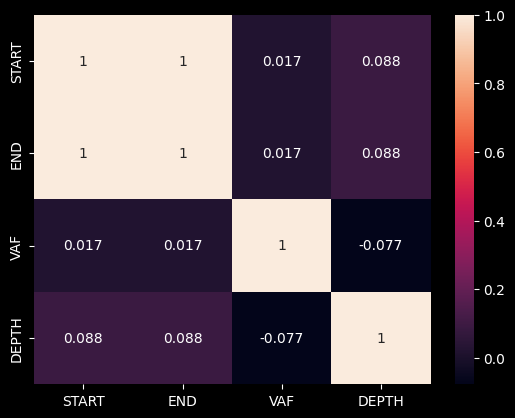

In [73]:
sns.heatmap(molecular_df.corr(), annot=True)
plt.show()

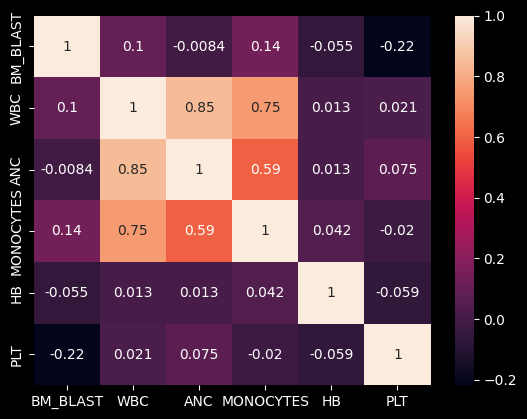

In [74]:
sns.heatmap(clinical_df.corr(), annot=True)
plt.show()

In [75]:
target_df.dropna(inplace=True)
print('shape of target:',target_df.shape)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool).map({True:1,False:0}) # bool values of Living (1) and Deceased (0) patients
print('type of target:\n',target_df.dtypes)



shape of target: (3173, 3)
type of target:
 ID            object
OS_YEARS     float64
OS_STATUS      int64
dtype: object


Let's first consider only the numerical features

In [76]:
features = clinical_df.select_dtypes(include=[np.number]).columns.tolist()
X = clinical_df.loc[clinical_df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

### Train - Test Dataset split

Split into train and test dataset

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Use of an imputer to fill the missing values, here KNN imputer

In [78]:
imputer = KNNImputer(n_neighbors=4)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
# Convert the imputed data back to DataFrame for comparison
X_train_imputed = pd.DataFrame(X_train, columns=features)
X_test_imputed = pd.DataFrame(X_test, columns=features)

Imputer can induce a bias, let's verify that there is no significant bias introduced by the KNN imputer

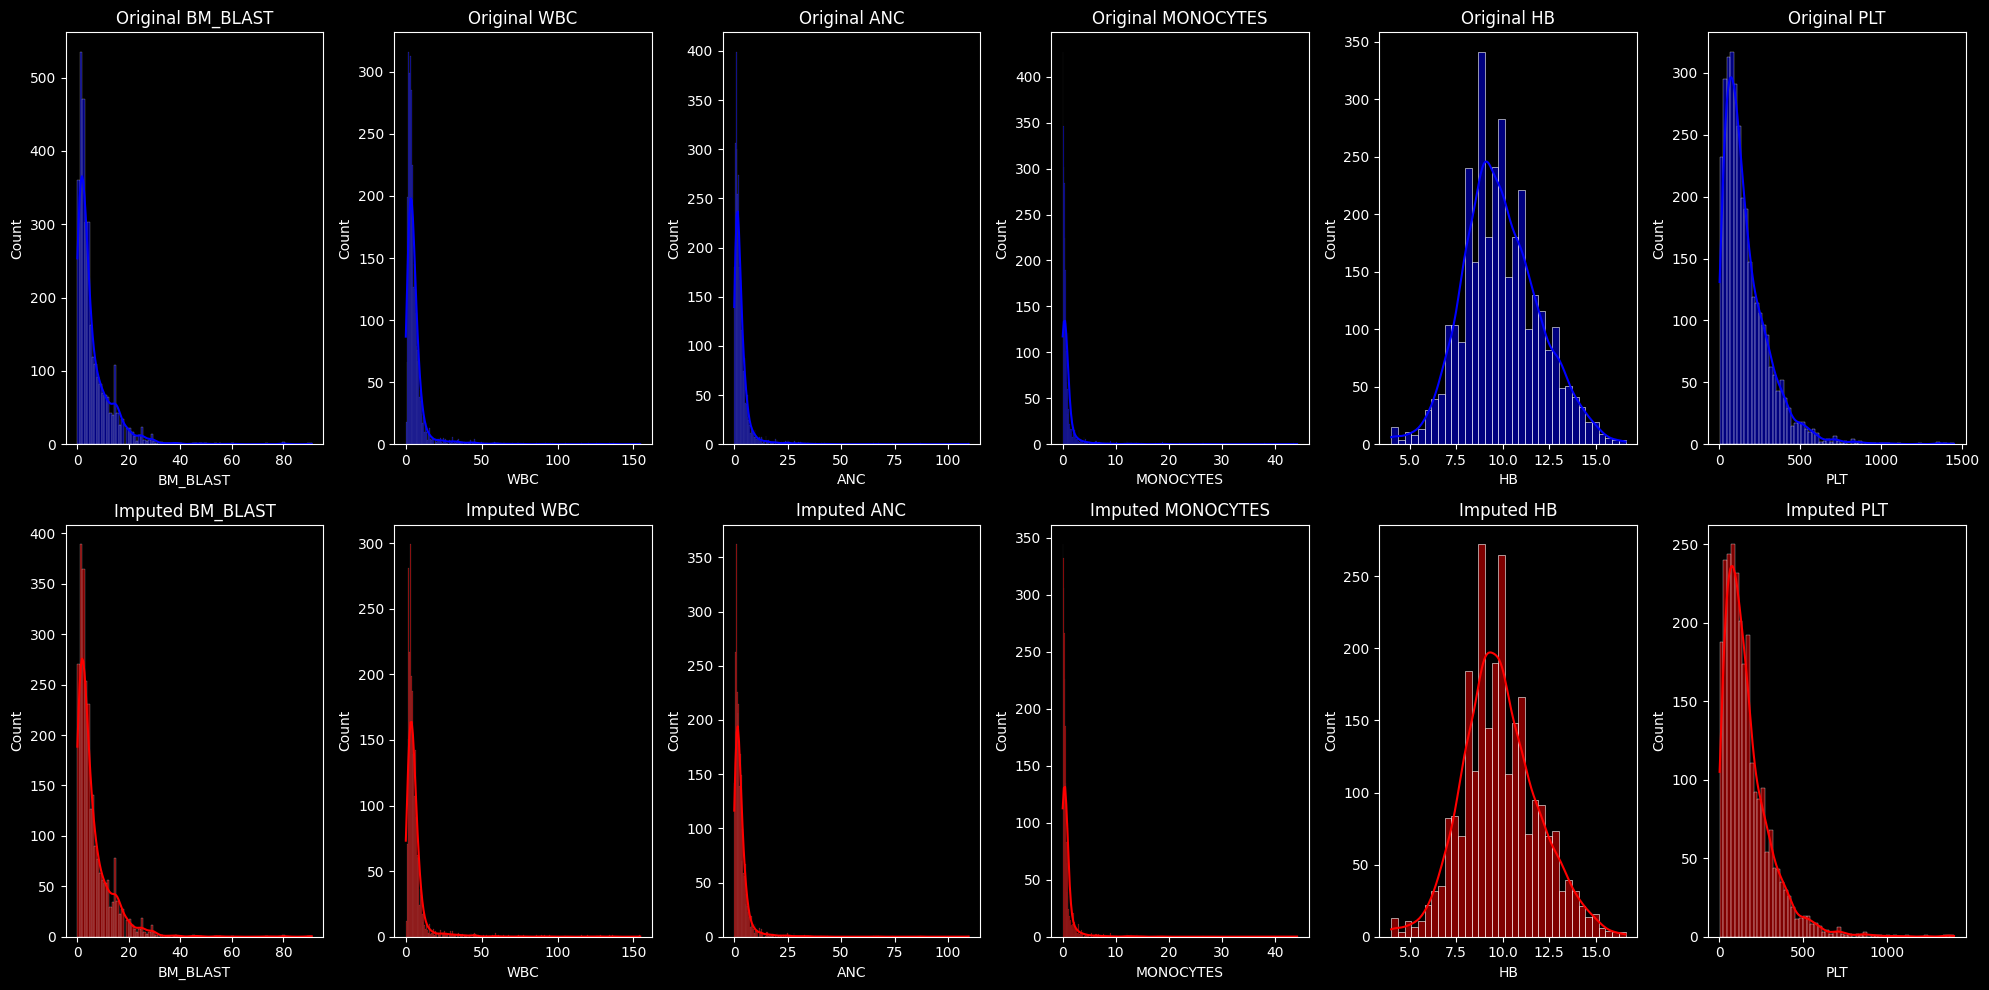

In [79]:
# Plot the distribution of original and imputed data
fig, axes = plt.subplots(nrows=2, ncols=len(features), figsize=(20, 10))

for i, feature in enumerate(features):
    sns.histplot(clinical_df[feature].dropna(), ax=axes[0, i], kde=True, color='blue')
    axes[0, i].set_title(f'Original {feature}')
    
    sns.histplot(X_train_imputed[feature], ax=axes[1, i], kde=True, color='red')
    axes[1, i].set_title(f'Imputed {feature}')

plt.tight_layout()
plt.show()

In [80]:
# Perform Kolmogorov-Smirnov test to compare original and imputed data distributions
ks_results = {}
for feature in features:
    original_data = clinical_df[feature].dropna()
    imputed_data = X_train_imputed[feature]
    ks_stat, p_value = ks_2samp(original_data, imputed_data)
    ks_results[feature] = {'KS Statistic': ks_stat, 'p-value': p_value}

ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)

           KS Statistic   p-value
BM_BLAST       0.022230  0.476217
WBC            0.011580  0.991085
ANC            0.011146  0.993999
MONOCYTES      0.023512  0.452826
HB             0.017356  0.777609
PLT            0.014549  0.919752


The KS stat is close to zero so the distributions are likely similar and the p-values are high so there are no strong evidence that prove that the distributions might differ.

### Training ML Models

Here is a basic approach using Cox Proportional Hazards Model with only the clinical dataset and without taking into account the non-numerical features

In [81]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.67
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.67


Before looking at the molecular datase, we can study the non-numerical features of the clinical dataset.$\\$
- CENTER: Represents the clinical site where the data was collected. They could reflect the differences in patient demographics or treatment protocols used.
- CYTOGENETICS: Complex chromosomal information in ISCN notation. Can have a strong predictive power of disease risk and is more difficult to analyse due to its format. We can extract data on the Male/Female gender of patients and chromosomal abnomalities such as monosomy 7 which probably significantly increases the risks of diseases.

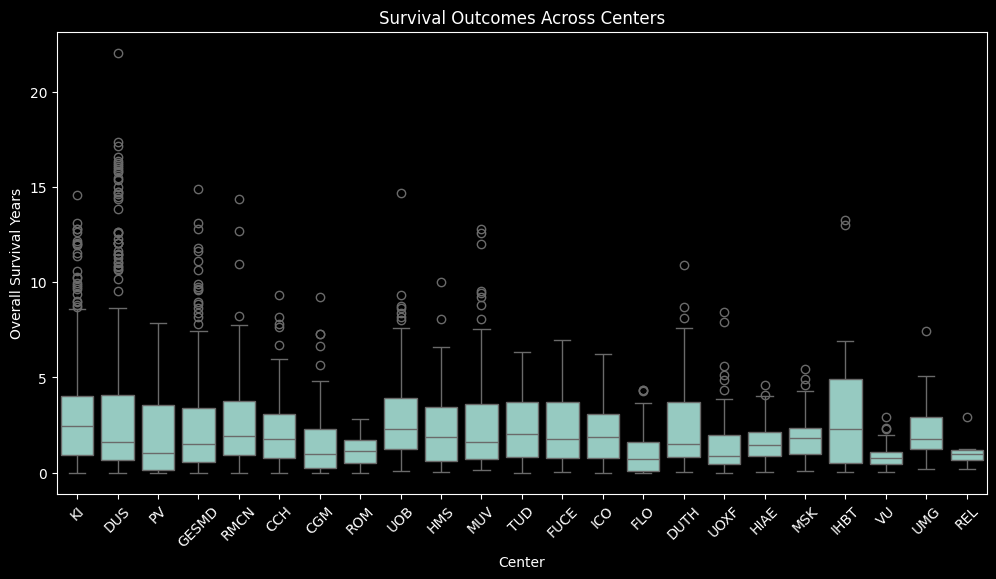

ANOVA F-statistic: 7.27
ANOVA p-value: 0.0000


In [82]:
from scipy.stats import f_oneway

# Merge clinical_df with target_df to include survival outcomes
merged_df = clinical_df.merge(target_df, on='ID')

# Boxplot to visualize survival outcomes across centers
plt.figure(figsize=(12, 6))
# Sort centers by their frequency in the dataset
sorted_centers = clinical_df['CENTER'].value_counts().index

# Create a boxplot with sorted centers
sns.boxplot(x='CENTER', y='OS_YEARS', data=merged_df, order=sorted_centers)
plt.title('Survival Outcomes Across Centers')
plt.xlabel('Center')
plt.ylabel('Overall Survival Years')
plt.xticks(rotation=45)
plt.show()

# Perform ANOVA to test if survival outcomes vary significantly across centers

# Group data by center and extract survival years
grouped_data = [group['OS_YEARS'].values for name, group in merged_df.groupby('CENTER')]

# Perform ANOVA
anova_result = f_oneway(*grouped_data)
print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")

ANOVA Results

- F-statistic: 7.27
    This measures the ratio of variance between the groups (centers) to the variance within the groups. A higher value suggests that the differences between the groups are more significant compared to the variability within each group.

- p-value: 0.0000
    This indicates the probability of observing these differences (or more extreme) under the null hypothesis that there are no differences between centers in their effect on the outcome (e.g., overall survival). A p-value of 0.0000 suggests that the result is statistically significant.

Interpretation

- Reject the null hypothesis (H₀): There is strong evidence that CENTER has a significant impact on the outcome (e.g., overall survival). The survival outcomes are not evenly distributed across the different centers.

- Implications:
        The variability across centers might reflect differences in patient populations, clinical protocols, or data collection practices.
        CENTER could be an important predictor and should be included in the model.

In [83]:
clinical_df['CENTER'].value_counts()

KI       900
DUS      455
PV       316
GESMD    246
RMCN     199
CCH      159
CGM      107
ROM      104
UOB       88
HMS       83
MUV       83
TUD       73
FUCE      73
ICO       71
FLO       68
DUTH      66
UOXF      50
HIAE      47
MSK       37
IHBT      33
VU        33
UMG       26
REL        6
Name: CENTER, dtype: int64

In [84]:
X_c = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y_c = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)
target_mean = X_c.merge(target_df[['ID', 'OS_YEARS']], on='ID').groupby('CENTER')['OS_YEARS'].mean()
X_c['CENTER'] = X_c['CENTER'].map(target_mean)

#scaler = StandardScaler()
#X_c['CENTER'] = scaler.fit_transform(X_c[['CENTER']])
X_c = X_c.drop(columns=['CYTOGENETICS','ID'])
X_c.head()

,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
0,1.932395,14.0,2.8,0.2,0.7,7.6,119.0
1,1.932395,1.0,7.4,2.4,0.1,11.6,42.0
2,1.932395,15.0,3.7,2.1,0.1,14.2,81.0
3,1.932395,1.0,3.9,1.9,0.1,8.9,77.0
4,1.932395,6.0,128.0,9.7,0.9,11.1,195.0


In [85]:
"""
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.2, random_state=0)
imputer = KNNImputer(n_neighbors=4)
X_c_train = imputer.fit_transform(X_c_train)
X_c_test = imputer.transform(X_c_test)
"""

'\nX_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.2, random_state=0)\nimputer = KNNImputer(n_neighbors=4)\nX_c_train = imputer.fit_transform(X_c_train)\nX_c_test = imputer.transform(X_c_test)\n'

In [129]:
class CoxModelEvaluator:
    def __init__(self, X, y, n_splits=5, random_state=0):
        self.X = X
        self.y = y
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.cox_cindex_c_train_scores = []
        self.cox_cindex_c_test_scores = []

    def evaluate_model(self, imputer=KNNImputer(n_neighbors=4)):
        self.cox_cindex_c_train_scores = [] # Rest previous scores
        self.cox_cindex_c_test_scores = []
        for train_index, test_index in self.kf.split(self.X,self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            imputer = imputer
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            cox_c = CoxPHSurvivalAnalysis()
            cox_c.fit(X_train, y_train)

            cox_cindex_c_train = concordance_index_ipcw(y_train, y_train, cox_c.predict(X_train), tau=7)[0]
            cox_cindex_c_test = concordance_index_ipcw(y_train, y_test, cox_c.predict(X_test), tau=7)[0]

            self.cox_cindex_c_train_scores.append(cox_cindex_c_train)
            self.cox_cindex_c_test_scores.append(cox_cindex_c_test)

        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on train: {np.mean(self.cox_cindex_c_train_scores):.2f}")
        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on test: {np.mean(self.cox_cindex_c_test_scores):.2f}")


evaluator = CoxModelEvaluator(X_c, y_c)
evaluator.evaluate_model()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Cox Proportional Hazard Model Concordance Index IPCW on train: 0.67
Average Cox Proportional Hazard Model Concordance Index IPCW on test: 0.67


In [87]:
"""
imputer = KNNImputer(n_neighbors=4)
X_c_train = imputer.fit_transform(X_c_train)
X_c_test = imputer.transform(X_c_test)

# Initialize and train the Cox Proportional Hazards model
cox_c = CoxPHSurvivalAnalysis()
cox_c.fit(X_c_train, y_c_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_c_train = concordance_index_ipcw(y_c_train, y_c_train, cox_c.predict(X_c_train), tau=7)[0]
cox_cindex_c_test = concordance_index_ipcw(y_c_train, y_c_test, cox_c.predict(X_c_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_c_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_c_test:.2f}")
"""

'\nimputer = KNNImputer(n_neighbors=4)\nX_c_train = imputer.fit_transform(X_c_train)\nX_c_test = imputer.transform(X_c_test)\n\n# Initialize and train the Cox Proportional Hazards model\ncox_c = CoxPHSurvivalAnalysis()\ncox_c.fit(X_c_train, y_c_train)\n\n# Evaluate the model using Concordance Index IPCW\ncox_cindex_c_train = concordance_index_ipcw(y_c_train, y_c_train, cox_c.predict(X_c_train), tau=7)[0]\ncox_cindex_c_test = concordance_index_ipcw(y_c_train, y_c_test, cox_c.predict(X_c_test), tau=7)[0]\nprint(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_c_train:.2f}")\nprint(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_c_test:.2f}")\n'

No apparent benefits from that kind of approach of CENTER, there is a bais introduced by the inbalance in data

CYTOGENETICS (Textual/Structured Data):

- Categorization:
    - Extract meaningful groups from the notation:
        - Normal vs. Abnormal: Check if the karyotype is 46,XX/46,XY or abnormal (e.g., -7, +8, etc.).
        - Type of Abnormalities: Group abnormalities by type (e.g., monosomies, trisomies, translocations, deletions, etc.).
    - Consider domain knowledge or clinical literature to classify abnormalities into risk categories (e.g., high-risk, intermediate-risk, low-risk).

- Feature Engineering:
    - Binary indicators: Create binary columns for specific abnormalities (e.g., IS_MONOSOMY_7 = 1 if monosomy 7 is present, else 0).
    - Count-based features: Count the number of abnormalities (e.g., NUM_ABNORMALITIES).
    - Risk scores: Assign numerical risk scores based on cytogenetic findings (e.g., from clinical guidelines).

- Text Processing (Advanced):
    - Use Natural Language Processing (NLP) techniques to process the structured ISCN text:
        - Tokenize the karyotype notation.
        - Use a bag-of-words or TF-IDF vectorizer to create numerical features.
        - Employ pretrained biomedical embeddings to represent the text (e.g., BioBERT).

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

X_f = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y_f = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)
target_mean = X_f.merge(target_df[['ID', 'OS_YEARS']], on='ID').groupby('CENTER')['OS_YEARS'].mean()
X_f.loc[:, 'CENTER'] = X_f['CENTER'].map(target_mean)

"""
vectorizer = CountVectorizer()
X_f['CYTOGENETICS'] = X_f['CYTOGENETICS'].fillna('NA')
vector = vectorizer.fit_transform(X_f['CYTOGENETICS'])
vectorizer.vocabulary_
"""


"\nvectorizer = CountVectorizer()\nX_f['CYTOGENETICS'] = X_f['CYTOGENETICS'].fillna('NA')\nvector = vectorizer.fit_transform(X_f['CYTOGENETICS'])\nvectorizer.vocabulary_\n"

In [89]:
X_f.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,1.932395,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,1.932395,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,1.932395,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,1.932395,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,1.932395,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [90]:
X_f['CYTOGENETICS'].value_counts()

46,xy[20]                                                                                                                         426
46,xx[20]                                                                                                                         251
46,xy                                                                                                                             241
46,xx                                                                                                                             153
46,xy[25]                                                                                                                          61
                                                                                                                                 ... 
47,xx,+xc[20]                                                                                                                       1
46,xx,del(5)(q13q31)[18]/46,xx[2]                             

In [91]:
X_f['MONOSOMY 7'] = X_f['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})


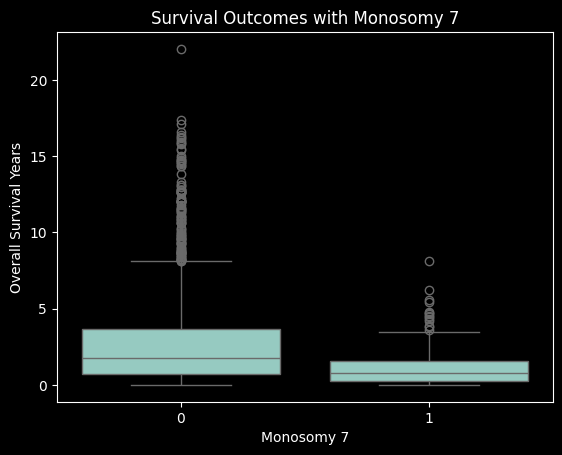

In [92]:
merged_mono = X_f.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 7', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 7')
plt.xlabel('Monosomy 7')
plt.ylabel('Overall Survival Years')
plt.show()


In [93]:
X_f = X_f.drop(columns=['CYTOGENETICS','ID'])

In [94]:
eval_mono = CoxModelEvaluator(X_f, y_f)
eval_mono.evaluate_model()

Average Cox Proportional Hazard Model Concordance Index IPCW on train: 0.68
Average Cox Proportional Hazard Model Concordance Index IPCW on test: 0.67


In [95]:
clinical_df['CYTOGENETICS'].iloc[:10]


0         46,xy,del(20)(q12)[2]/46,xy[18]
1                                   46,xx
2      46,xy,t(3;3)(q25;q27)[8]/46,xy[12]
3       46,xy,del(3)(q26q27)[15]/46,xy[5]
4     46,xx,t(3;9)(p13;q22)[10]/46,xx[10]
5                               46,xx[20]
6                               46,xy[20]
7                               46,xy[20]
8    45,xx,del(5)(q13q33),inc[2]/46,xx[2]
9                               46,xx[20]
Name: CYTOGENETICS, dtype: object

#### regex to extract information out of cytogenetics data

In [96]:
import re
def parse_cytogenetics(cytogenetics_str):
    modal_number_match = re.search(r'^\d+', cytogenetics_str)
    modal_number = modal_number_match.group() if modal_number_match else None  # Extract modal number
    sex_chromosomes_match = re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE)
    sex_chromosomes = sex_chromosomes_match.group() if sex_chromosomes_match else None  # Extract sex chromosomes
    abnormalities = re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', cytogenetics_str)
    subclones = re.findall(r'/\d+', cytogenetics_str)
    return {
        "modal_number": modal_number,
        "sex_chromosomes": sex_chromosomes,
        "abnormalities": abnormalities,
        "subclones": subclones
    }

# Example input
cytogenetics_str = clinical_df['CYTOGENETICS'].iloc[12]
parsed = parse_cytogenetics(cytogenetics_str)
print(parsed)


clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_df['GENDER'] = clinical_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_df['NUM_ABNORMALITIES'] = clinical_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_df['CHROMOSOME_DIFF'] = clinical_df['CYTOGENETICS'].apply(lambda x: int(re.search(r'^\d+', x).group()) - 46 if re.search(r'^\d+', x) else 0)

print(clinical_df[['GENDER', 'NUM_ABNORMALITIES', 'CHROMOSOME_DIFF']].head())

{'modal_number': '45', 'sex_chromosomes': 'xy', 'abnormalities': ['-7'], 'subclones': ['/46']}
   GENDER  NUM_ABNORMALITIES  CHROMOSOME_DIFF
0     1.0                  1                0
1     0.0                  0                0
2     1.0                  1                0
3     1.0                  1                0
4     0.0                  1                0


In [97]:

re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE).group()

'xy'

In [98]:
clinical_df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.0,1,0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.0,0,0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1.0,1,0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1.0,1,0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.0,1,0


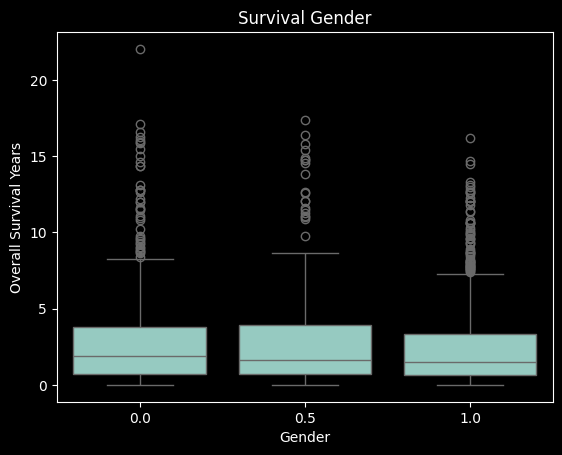

In [99]:
merged_df_cyto = clinical_df.merge(target_df, on='ID')

sns.boxplot(x='GENDER', y='OS_YEARS', data=merged_df_cyto)
plt.title('Survival Gender')
plt.xlabel('Gender')
plt.ylabel('Overall Survival Years')
plt.show()

The gender seems to be unrelated to the individual's survival

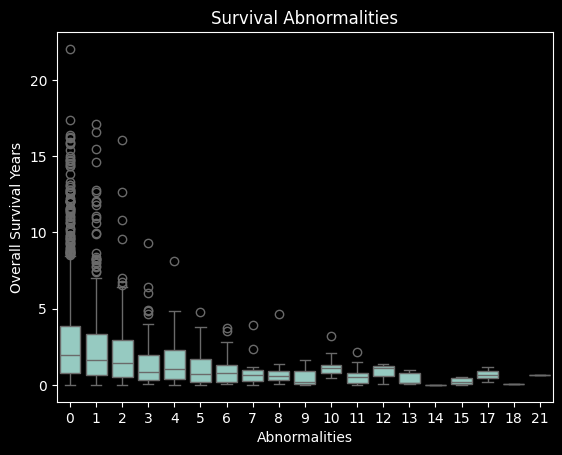

In [100]:
sns.boxplot(x='NUM_ABNORMALITIES', y='OS_YEARS', data=merged_df_cyto)
plt.title('Survival Abnormalities')
plt.xlabel('Abnormalities')
plt.ylabel('Overall Survival Years')
plt.show()

The more Abnormalities one has, the less likely he would live long

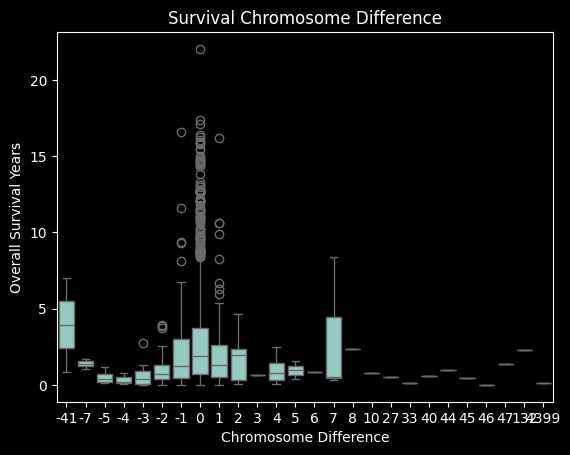

In [101]:
sns.boxplot(x='CHROMOSOME_DIFF', y='OS_YEARS', data=merged_df_cyto)
plt.title('Survival Chromosome Difference')
plt.xlabel('Chromosome Difference')
plt.ylabel('Overall Survival Years')
plt.show()



In [102]:
X_cyto = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y_cyto = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)
X_cyto = X_cyto.drop(columns=['CYTOGENETICS','ID','GENDER','CENTER'])

eval_cyto = CoxModelEvaluator(X_cyto, y_cyto)
eval_cyto.evaluate_model()

Average Cox Proportional Hazard Model Concordance Index IPCW on train: 0.68
Average Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68


In [103]:
tmp = molecular_df.groupby('ID').size().reset_index(name='Nb mut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
X_mol = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()

X_mol = X_mol.merge(tmp, on='ID', how='left').fillna({'Nb mut': 0})

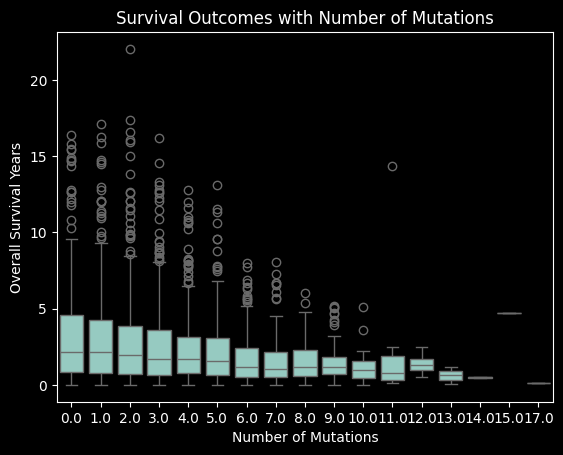

In [104]:
merged_mol = X_mol.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='Nb mut', y='OS_YEARS', data=merged_mol)
plt.title('Survival Outcomes with Number of Mutations')
plt.xlabel('Number of Mutations')
plt.ylabel('Overall Survival Years')
plt.show()

In [140]:
merged_mol.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,OS_YEARS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.0,1,0,9.0,1.115068
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.0,0,0,3.0,4.928767
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1.0,1,0,3.0,2.043836
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1.0,1,0,11.0,2.476712
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.0,1,0,1.0,3.145205


In [105]:
X_mol_train = X_mol.drop(columns=['CYTOGENETICS','ID','CENTER','GENDER','WBC','ANC'])

In [106]:
eval_mol = CoxModelEvaluator(X_mol_train, y_cyto)
eval_mol.evaluate_model(imputer=SimpleImputer(strategy='mean'))

Average Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Average Cox Proportional Hazard Model Concordance Index IPCW on test: 0.71


In [107]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


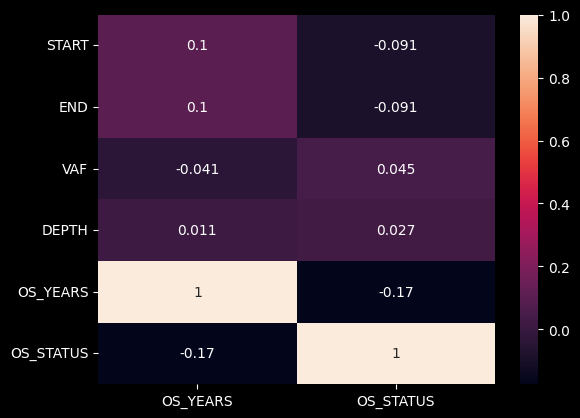

In [108]:
molecular_df.iloc[5:20]
# Merge molecular_df with target_df on 'ID'
merged_molecular_target_df = molecular_df.merge(target_df, on='ID')

# Calculate the correlation between molecular features and survival outcomes
correlation_matrix = merged_molecular_target_df.corr()

# Extract the correlation of molecular features with 'OS_YEARS' and 'OS_STATUS'
correlation_with_outcomes = correlation_matrix[['OS_YEARS', 'OS_STATUS']]

sns.heatmap(correlation_with_outcomes, annot=True)
plt.show()

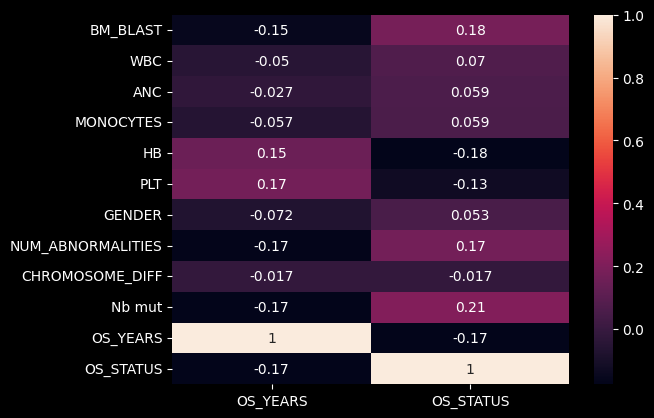

In [109]:
# Merge molecular_df with target_df on 'ID'
merged_molecular_target_df = X_mol.merge(target_df, on='ID')

# Calculate the correlation between molecular features and survival outcomes
correlation_matrix = merged_molecular_target_df.corr()

# Extract the correlation of molecular features with 'OS_YEARS' and 'OS_STATUS'
correlation_with_outcomes = correlation_matrix[['OS_YEARS', 'OS_STATUS']]

sns.heatmap(correlation_with_outcomes, annot=True)
plt.show()

In [110]:
molecular_df['EFFECT'].unique()
effect_weights = {
    'frameshift_variant': 15,
    'stop_gained': 14,
    'splice_site_variant': 13,
    'stop_lost': 12,
    'ITD (Internal Tandem Duplication)': 11,
    'PTD (Partial Tandem Duplication)': 10,
    'non_synonymous_codon': 9,
    'inframe_variant': 8,
    'inframe_codon_loss': 7,
    'inframe_codon_gain': 6,
    'initiator_codon_change': 5,
    'complex_change_in_transcript': 4,
    '2KB_upstream_variant': 3,
    '3_prime_UTR_variant': 2,
    'synonymous_codon': 1,
    'stop_retained_variant': 0
}

molecular_df['EFFECT'] = molecular_df['EFFECT'].map(effect_weights).fillna(0)



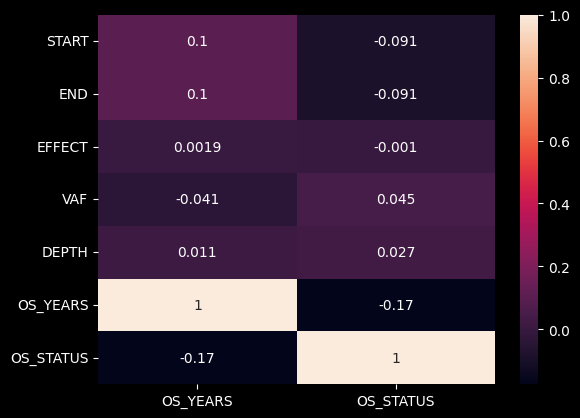

In [111]:
merged_molecular_target_df = molecular_df.merge(target_df, on='ID')

# Calculate the correlation between molecular features and survival outcomes
correlation_matrix = merged_molecular_target_df.corr()

# Extract the correlation of molecular features with 'OS_YEARS' and 'OS_STATUS'
correlation_with_outcomes = correlation_matrix[['OS_YEARS', 'OS_STATUS']]

sns.heatmap(correlation_with_outcomes, annot=True)
plt.show()

### Random Survival Forest

In [123]:
rsf = RandomSurvivalForest(
    n_estimators=200,         
    min_samples_split=30,     
    min_samples_leaf=15,       
    max_features=0.5,      
    random_state=42,          
    n_jobs=-1                 
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rsf_cindex_train = []
rsf_cindex_test = []

for train_index, test_index in kf.split(X_mol_train, y_cyto):
    X_train, X_test = X_mol_train.iloc[train_index], X_mol_train.iloc[test_index]
    y_train, y_test = y_cyto[train_index], y_cyto[test_index]
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    rsf.fit(X_train, y_train)

    rsf_cindex_train_val = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train),tau = 7)[0]
    rsf_cindex_test_val = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test),tau = 7)[0]
    rsf_cindex_train.append(rsf_cindex_train_val)
    rsf_cindex_test.append(rsf_cindex_test_val)

print(f"Average Random Survival Forest ipcw-Index train: {np.mean(rsf_cindex_train):.4f}")
print(f"Average Random Survival Forest ipcw-Index test: {np.mean(rsf_cindex_test):.4f}")



c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Random Survival Forest ipcw-Index train: 0.7650
Average Random Survival Forest ipcw-Index test: 0.7049


In [138]:
def grid_search_rsf(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for RSF.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        # Initialize RSF with current parameter set
        rsf_params = dict(zip(param_names, params))
        rsf = RandomSurvivalForest(**rsf_params, random_state=42, n_jobs=-1)

        # Cross-validation setup
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            i += 1
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Handle missing data
            imputer = SimpleImputer(strategy="mean")
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            # Fit RSF model
            rsf.fit(X_train, y_train)

            # Evaluate IPCW concordance index
            train_score = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        print(f"step {i}/{n}")
        # Average test score for this parameter set
        mean_test_score = np.mean(test_scores)
        print(f"Params: {rsf_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        # Update best parameters if the current score is better
        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = rsf_params

    return best_params, best_score


In [137]:
param_grid = {
    "n_estimators": [100,200],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 5],
    "max_features": ["sqrt"],
    "max_depth": [None, 5, 10, 15]
}

# Perform grid search
best_params, best_score = grid_search_rsf(X_mol_train, y_cyto, param_grid, n_splits=3, tau=7)

print("\nBest Parameters:", best_params)
print("Best Test Concordance Index:", best_score)


step 1/32
step 2/32
step 3/32
Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}, Train Score: 0.8749, Test Score: 0.6978
step 4/32
step 5/32
step 6/32
Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5}, Train Score: 0.7265, Test Score: 0.7012
step 7/32
step 8/32
step 9/32
Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}, Train Score: 0.7935, Test Score: 0.7036
step 10/32
step 11/32
step 12/32
Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}, Train Score: 0.8574, Test Score: 0.7009
step 13/32
step 14/32
step 15/32
Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}, Train Score: 0.8178, Test Score: 0.7036
step 16/32
step 17/32
step 18/32
Params: {'n_e